In [1]:
import pandas as pd
import numpy as np
import sklearn
import torch
import os
import matplotlib.pyplot as plt

In [17]:
from IPython.display import Image
from IPython.display import display
import cv2
import pickle

Q1: Exploratory Data Analysis (4 Pts)
Download and explore the data. Explore label distribution and qualitatively describe the data by
plotting healthy and pneumonia samples. Do you see visual differences between healthy and
disease samples? Do you find sources of bias that could influence model performance? How do
you preprocess the data for your further analysis?

Download and explore the data. Explore label distribution

In [4]:
def count_samples(dir_path, filter_phrase=""):
    count = 0
    # Iterate directory
    for PATH in os.listdir(dir_path):
        # check if current path is a file
        if os.path.isfile(os.path.join(dir_path, PATH)):
            if filter_phrase in os.path.basename(PATH):
                count += 1
    #account for duplicate Identifier files
    return int(count/2)


print(f"Number of healthy training samples: {count_samples(r'chest_xray/train/NORMAL')}")
phrase = "bacteria"
print(f"Number of bacterial pneumonia training samples: {count_samples(r'chest_xray/train/PNEUMONIA', phrase)}")
phrase = "virus"
print(f"Number of viral pneumonia training samples: {count_samples((r'chest_xray/train/PNEUMONIA'), phrase)}")



Number of healthy training samples: 1342
Number of bacterial pneumonia training samples: 2530
Number of viral pneumonia training samples: 1345


and qualitatively describe the data by plotting healthy and pneumonia samples.

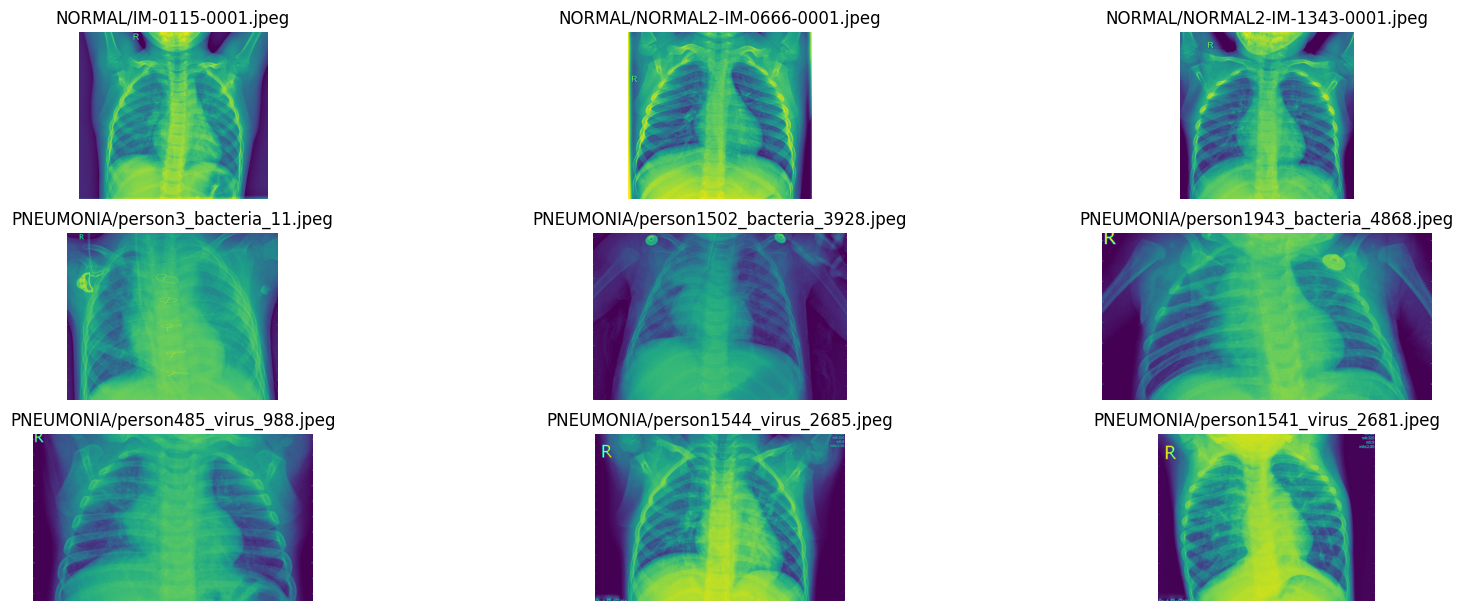

In [5]:
def plot_image_rows(file_names, columns=3):
    #plot images corresponding to list of file names in a horizontal row
    plt.figure(figsize=(20,10))
    
    for i, name in enumerate(file_names):
        #create subplots to match grid
        plt.subplot(len(file_names) // columns + 1, columns, i + 1)
        plt.imshow(plt.imread(name))
        plt.axis('off')
        #get title
        title = str.split(name, '/')
        plt.title(title[2] + "/" + title[3])


BASEPATH_0 = "chest_xray/train/NORMAL/"
BASEPATH_1 = "chest_xray/train/PNEUMONIA/"
file_names = [
    BASEPATH_0 + "IM-0115-0001.jpeg",
    BASEPATH_0 + "NORMAL2-IM-0666-0001.jpeg",
    BASEPATH_0 + "NORMAL2-IM-1343-0001.jpeg",

    BASEPATH_1 + "person3_bacteria_11.jpeg",
    BASEPATH_1 + "person1502_bacteria_3928.jpeg",
    BASEPATH_1 + "person1943_bacteria_4868.jpeg",
    
    BASEPATH_1 + "person485_virus_988.jpeg",
    BASEPATH_1 + "person1544_virus_2685.jpeg",
    BASEPATH_1 + "person1541_virus_2681.jpeg",
]

plot_image_rows(file_names)


Do you see visual differences between healthy and disease samples?

Do you find sources of bias that could influence model performance?

How do you preprocess the data for your further analysis?

Resize all to same area. Use Grayscale since color information is not relevant to this task.

In [18]:
classes = ['PNEUMONIA', 'NORMAL']
shape = (150, 150)

def preprocess(DATADIR):
    #turns images in folder into tuple list of image data as numpy array and class
    X_y = [] 
    for class_ in classes: 
        PATH = DATADIR + "/" + class_
        #save class label as number for compactness
        class_num = classes.index(class_)
        for image_name in os.listdir(PATH):
            if not ("Zone.Identifier" in image_name) and not (".DS_Store" in image_name):
                images = cv2.imread(os.path.join(PATH, image_name), cv2.IMREAD_GRAYSCALE)
                resized_images = cv2.resize(images, shape)
                X_y.append([resized_images, class_num])
             
    return X_y


data_sets = ["train", "test", "val"]
for kind in data_sets:
    file = open("2_" + kind + "_data.pkl", 'wb')
    X_y = preprocess("chest_xray/" + kind + "/")
    pickle.dump(X_y, file)
    file.close()


Q2: CNN Classifier (4 Pts)
In Q3 and Q4, we aim to use post-hoc explainability methods for visualizing the parts of the image that are important for the prediction of a model. Thus, design a small CNN classifier for the dataset and report its performance on a test set. Make sure to elaborate on your architecture and training details.

design a small CNN classifier for the dataset and report its performance on a test set

Make sure to elaborate on your architecture and training details.

Q3: Integrated Gradients5 (4 Pts)
Like MLPs, CNNs perform very well in tasks like classification but lack interpretability due to their black-box nature. Again, post-hoc explainability methods are thus suitable alternatives.
One class of post-hoc procedures specific to image data are methods generating attribution
maps, which try to highlight the most important regions on which the CNN bases its predictions.
For this part of the assignment, implement the integrated gradient method. Visualize attribution

For this part of the assignment, implement the integrated gradient method.

Visualize attribution

Q4: Grad-CAM6 (5 Pts)
Grad-CAM is another post-hoc method that generates attribution maps. Like in Q3, implement
the method and visualize attribution maps of five healthy and five disease test samples. Do the maps highlight sensible regions? Are attributions consistent across samples? Compare your
findings with Q3.

implement the method

visualize attribution maps of five healthy and five disease test samples

Do the maps highlight sensible regions?

Are attributions consistent across samples?

Compare your findings with Q3.

Q5: Data Randomization Test7 (3 Pts)
Recently, the paper “Sanity Checks for Saliency Maps.” introduced the data randomization test
to check how trustworthiness of the saliency maps of specific methods. They propose to retrain
the classifier on the train set when randomly permuting labels of all samples. Then, they
compare the saliency maps on test samples for the perturbed and unperturbed classifiers. We
expect the map to change if an attribution map accurately captures the relationship between
instances and their labels. Conversely, if the attribution map captures another concept, e.g., acts
like an edge detector independent of the label, we expect the maps to stay the same. Retrain
your CNN on random training labels and perform the Data randomization Test for both
Integrated Gradients and Grad-CAM. Do they pass or fail? Elaborate and visualize your
findings!

Retrain your CNN on random training labels

perform the Data randomization Test for both Integrated Gradients and Grad-CAM

Do they pass or fail?

Elaborate and visualize your findings!

Challenge 2: Prototype Learning (10 Pts)
A radically different idea for interpretable classification is finding prototypical samples for each
class. Then, in addition to the prediction, we can return the prototype most similar to the input.
This idea was explored in the paper “Examples are not Enough, Learn to Criticize! Criticism for
Interpretability”8. They provide a method that allows you to extract representative prototypes
from a given dataset by using the maximum mean discrepancy (MMD) measure as a distance
function and introducing a kNN-like classifier. After reading the paper, we ask you to implement
their method in two steps:
1.
Implement the “Nearest Prototype Classifier” described in Section 5 of the paper. For
now, set the set of prototypes S to be random points of the training set. Report the
classification performance of this model on the test set.
2.
Implement the function Jb(S) (Section 3) and select prototypes S through their greedy
algorithm (Algorithm 1). Refit the classifier, this time with the selected prototypes, and
compare classification performance to random prototypes. Does the result behave as
you expected? Why or why not? Visualize five healthy and five disease prototypes. Do
you find representative class patterns among them? Would you say they look
prototypical?
How could you improve performance beyond simply applying kNN to the raw images? Compare
this type of interpretable method to the previously seen saliency maps. Which method do you
think is more useful? Can you think of scenarios where one is more valuable than the other?

Implement the “Nearest Prototype Classifier” described in Section 5 of the paper. For
now, set the set of prototypes S to be random points of the training set. 

Report the classification performance of this model on the test set.

Implement the function Jb(S) (Section 3) and select prototypes S through their greedy
algorithm (Algorithm 1).

Refit the classifier, this time with the selected prototypes, and
compare classification performance to random prototypes. 

Does the result behave as you expected? Why or why not?

Visualize five healthy and five disease prototypes. 

Do you find representative class patterns among them? Would you say they look
prototypical?

How could you improve performance beyond simply applying kNN to the raw images? Compare
this type of interpretable method to the previously seen saliency maps. Which method do you
think is more useful? Can you think of scenarios where one is more valuable than the other?